<a href="https://colab.research.google.com/github/Bast-94/CYBERML-Project/blob/classification/cyber-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Cyber Security Project

In [1]:
!pip install -q openpyxl tensorflow xgboost

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [3]:
import pandas as pd
import numpy as np
import os
import sys
dir = "."
if os.path.exists(dir) and os.path.isdir(dir):
    # Si le répertoire existe, changez le chemin courant
    dir = '/content/drive/MyDrive/MSECU'
    sys.path.append(dir)
from mlsecu.anomaly_detection_use_case import *
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

## Prepare Data

### Loading dataset

In [4]:
dataset_path = os.path.join(dir,'data/SWaT.A3_dataset_Jul 19_labelled.xlsx')
df = pd.read_excel(dataset_path, header=1)

In [5]:
df.head()

GMT +0 Attack  Label FIT 101   LIT 101 MV 101  \
0                    timestamp    NaN    NaN   value     value  value   
1         2019-07-20T04:30:00Z    NaN    NaN       0  729.8658      1   
2         2019-07-20T04:30:01Z    NaN    NaN       0   729.434      1   
3  2019-07-20T04:30:02.004013Z    NaN    NaN       0    729.12      1   
4  2019-07-20T04:30:03.004013Z    NaN    NaN       0  728.6882      1   

  P1_STATE P101 Status P102 Status     AIT 201  ...  \
0    value       value       value       value  ...   
1        3           2           1  142.527557  ...   
2        3           2           1  142.527557  ...   
3        3           2           1  142.527557  ...   
4        3           2           1  142.527557  ...   

                                             LSH 601  \
0                                              value   
1  {u'IsSystem': False, u'Name': u'Active', u'Val...   
2  {u'IsSystem': False, u'Name': u'Active', u'Val...   
3  {u'IsSystem': False, u'Name': u'Active', u'Val...   
4  {u'IsSystem': False, u'Name': u'Active', u'Val...   

                                             LSH 602  \
0                                              value   
1  {u'IsSystem': False, u'Name': u'Active', u'Val...   
2  {u'IsSystem': False, u'Name': u'Active', u'Val...   
3  {u'IsSystem': False, u'Name': u'Active', u'Val...   
4  {u'IsSystem': False, u'Name': u'Active', u'Val...   

                                             LSH 603  \
0                                              value   
1  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
2  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
3  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
4  {u'IsSystem': False, u'Name': u'Inactive', u'V...   

                                             LSL 601  \
0                                              value   
1  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
2  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
3  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
4  {u'IsSystem': False, u'Name': u'Inactive', u'V...   

                                             LSL 602  \
0                                              value   
1  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
2  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
3  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
4  {u'IsSystem': False, u'Name': u'Inactive', u'V...   

                                             LSL 603 P6 STATE P601 Status  \
0                                              value    value       value   
1  {u'IsSystem': False, u'Name': u'Active', u'Val...        2           1   
2  {u'IsSystem': False, u'Name': u'Active', u'Val...        2           1   
3  {u'IsSystem': False, u'Name': u'Active', u'Val...        2           1   
4  {u'IsSystem': False, u'Name': u'Active', u'Val...        2           1   

  P602 Status P603 Status  
0       value       value  
1           1           1  
2           1           1  
3           1           1  
4           1           1  

[5 rows x 80 columns]

### Cleaning data

In order to work easier on our dataset we need to clean it properly.

In [7]:
# date_format = "%Y-%m-%dT%H:%M:%S.%fZ"
full_df = df.drop([0])
full_df = full_df.reset_index(drop=True)
full_df = full_df.rename(columns={'GMT +0':'Date'})
full_df['Attack'] = full_df['Attack'].fillna('benign')
full_df['Label'] = full_df['Label'].fillna(0).astype(int)
full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df.to_csv(os.path.join(dir, './data/SWaT.A3_dataset_Jul_19_labelled.csv'))

In [8]:
# convert all columns to their appropriate data types (float, int, datetime...)
is_float = lambda x: isinstance(x, float)
for col in full_df.columns:
  if col == 'Date':
    continue

  if full_df[col].apply(pd.to_numeric, errors='coerce').notna().all():
    full_df[col] = full_df[col].apply(pd.to_numeric, errors='coerce')

In [9]:
full_df.head(2)

Date  Attack  Label  FIT 101   LIT 101  MV 101  \
0 2019-07-20 04:30:00+00:00  benign      0      0.0  729.8658       1   
1 2019-07-20 04:30:01+00:00  benign      0      0.0  729.4340       1   

   P1_STATE  P101 Status  P102 Status     AIT 201  ...  \
0         3            2            1  142.527557  ...   
1         3            2            1  142.527557  ...   

                                             LSH 601  \
0  {u'IsSystem': False, u'Name': u'Active', u'Val...   
1  {u'IsSystem': False, u'Name': u'Active', u'Val...   

                                             LSH 602  \
0  {u'IsSystem': False, u'Name': u'Active', u'Val...   
1  {u'IsSystem': False, u'Name': u'Active', u'Val...   

                                             LSH 603  \
0  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
1  {u'IsSystem': False, u'Name': u'Inactive', u'V...   

                                             LSL 601  \
0  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
1  {u'IsSystem': False, u'Name': u'Inactive', u'V...   

                                             LSL 602  \
0  {u'IsSystem': False, u'Name': u'Inactive', u'V...   
1  {u'IsSystem': False, u'Name': u'Inactive', u'V...   

                                             LSL 603 P6 STATE  P601 Status  \
0  {u'IsSystem': False, u'Name': u'Active', u'Val...        2            1   
1  {u'IsSystem': False, u'Name': u'Active', u'Val...        2            1   

   P602 Status  P603 Status  
0            1            1  
1            1            1  

[2 rows x 80 columns]

Let's start by removing the columns that are not useful for our analysis.

We can focus on columns with `unique values`, because they present `no variance`.



In [10]:
# get columns with only one unique value (no variance)
unique_value_cols = []
for col in full_df.columns:
    if (len(full_df[col].unique()) == 1):
        unique_value_cols.append(col)
print('Columns with only one unique value: ', unique_value_cols)

Columns with only one unique value:  ['P102 Status', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'P2_STATE', 'P201 Status', 'P202 Status', 'P204 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'P302 Status', 'AIT 401', 'LS 401', 'P4_STATE', 'P402 Status', 'P403 Status', 'P404 Status', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P602 Status', 'P603 Status']


In [11]:
# let's plot 5 columns in unique_value_cols to see their shape
fig = make_subplots(rows=5, cols=1, subplot_titles=unique_value_cols[:5])

for i, col in enumerate(unique_value_cols[:5]):
    fig.add_trace(go.Scatter(x=full_df['Date'], y=full_df[col], name=col), row=i+1, col=1)

fig.update_layout(height=1000, width=1000, title_text="Columns with only one unique value")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Let's remove them from our dataset

In [12]:
# cleaned_df with the unique_value_cols removed
cleaned_df = full_df.drop(unique_value_cols, axis=1)
cleaned_df.head(2)

Date  Attack  Label  FIT 101   LIT 101  MV 101  \
0 2019-07-20 04:30:00+00:00  benign      0      0.0  729.8658       1   
1 2019-07-20 04:30:01+00:00  benign      0      0.0  729.4340       1   

   P1_STATE  P101 Status     AIT 201   AIT 202  ...   FIT 502   FIT 503  \
0         3            2  142.527557  9.293002  ...  0.310362  0.623628   
1         3            2  142.527557  9.293002  ...  0.315102  0.623628   

    FIT 504  MV 501     PIT 501   PIT 502     PIT 503  FIT 601  \
0  0.213432       2  167.601257  2.963509  119.921173  0.00032   
1  0.212984       2  167.601257  2.963509  119.921173  0.00032   

                                             LSH 601  P601 Status  
0  {u'IsSystem': False, u'Name': u'Active', u'Val...            1  
1  {u'IsSystem': False, u'Name': u'Active', u'Val...            1  

[2 rows x 47 columns]

Let's now display the `LIT 101` column.

In [13]:
features_chosen = ['LIT 101', 'LIT 301', 'AIT 301', 'AIT 302', 'AIT 202', 'AIT 203', 'FIT 201', 'DPIT 301']

features = cleaned_df[features_chosen]
features.index = cleaned_df['Date']
#print(features.head())

fig = make_subplots(rows=len(features_chosen), cols=1, subplot_titles=features_chosen)

# Add a line plot for each feature selected
for i, feature in enumerate(features_chosen, start=1):
    fig.add_trace(
        go.Scatter(x=features.index, y=features[feature], name=feature),
        row=i, col=1
    )

fig.update_layout(height=800, width=600, title_text="Multivariate Time Series")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

The `LSH 601` column is a categorical column, we notice that some of its values change during an attack period from 07:00 to 08:00.

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=full_df['Date'], y=full_df['LSH 601'], name='LSH 601'))

fig.update_layout(height=500, width=800, title_text="LSH 601")
fig.show()

In [15]:
cleaned_df.to_csv(os.path.join(dir,'data/SWaT.A3_dataset_Jul_19_labelled_cleaned.csv'))
cleaned_df.head(2)

Date  Attack  Label  FIT 101   LIT 101  MV 101  \
0 2019-07-20 04:30:00+00:00  benign      0      0.0  729.8658       1   
1 2019-07-20 04:30:01+00:00  benign      0      0.0  729.4340       1   

   P1_STATE  P101 Status     AIT 201   AIT 202  ...   FIT 502   FIT 503  \
0         3            2  142.527557  9.293002  ...  0.310362  0.623628   
1         3            2  142.527557  9.293002  ...  0.315102  0.623628   

    FIT 504  MV 501     PIT 501   PIT 502     PIT 503  FIT 601  \
0  0.213432       2  167.601257  2.963509  119.921173  0.00032   
1  0.212984       2  167.601257  2.963509  119.921173  0.00032   

                                             LSH 601  P601 Status  
0  {u'IsSystem': False, u'Name': u'Active', u'Val...            1  
1  {u'IsSystem': False, u'Name': u'Active', u'Val...            1  

[2 rows x 47 columns]

### Dimensionality reduction with Principal Component Analysis (PCA)

#### One-hot encoding (categorical data)

In [16]:
df_copy = cleaned_df.copy()
one_hot_encoded_df = get_one_hot_encoded_dataframe(df_copy.drop(columns=['Date', 'Attack', 'Label']))
no_nan_df = remove_nan_through_mean_imputation(one_hot_encoded_df)

#### PCA

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca = pca.fit(no_nan_df)

X_reduced = pca.transform(no_nan_df)
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance}')

Explained variance ratio: [0.57946309 0.31146125 0.05954082]


#### 3D representation

In [18]:
import plotly.graph_objects as go
import plotly.offline as py

def plot_3D_scatter(data: pd.DataFrame, dataset_name: str) -> None:
    """
    Show 3D plot of the input data.

    Args:
        data (pd.DataFrame): input data
    """
    layout = go.Layout(scene={"aspectmode": "cube"})
    layout['scene'].update(xaxis_title='X', yaxis_title='Y', zaxis_title='Z')
    layout['title'] = f"{dataset_name} Dataset distribution"
    fig = go.Figure(data=[go.Scatter3d(
        x=data['X'],
        y=data['Y'],
        z=data['Z'],
        mode='markers',
        text=data['Attack'],
        marker=dict(
            size=2,
            color=data['Color'],
            colorscale='Viridis',
            opacity=0.5
        )
    )], layout=layout)
    py.iplot(fig, show_link=False)

def get_color(name: str) -> str:
    d = {
        'benign': 'black',
        'Spoofing': 'mediumvioletred',
        'Switch_ON': 'darkviolet',
        'Switch_close': 'rebeccapurple',
        'Switch_off': 'seagreen'
    }
    return d[name]

X_reduced_df = pd.DataFrame(X_reduced)
X_reduced_df['Attack'] = cleaned_df['Attack']
X_reduced_df['Color'] = cleaned_df['Attack'].apply(get_color)
X_reduced_df = X_reduced_df.rename(columns={0: 'X', 1: 'Y', 2: 'Z'})

plot_3D_scatter(X_reduced_df, "SWaT")

## LSTM Model and RMS-deviation

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Data preparation

Our LSTM must take a specific shape of data. We need to reshape our data in order to fit the model.

Here our dataset has a shape of (14996,49). We know that the LSTM works better with 200-400 time steps per sample. We will use 300 time steps per sample.

15 000 / 60 = 250 samples

Let's have 49 samples with 300 time steps each and the last one with 296 time steps.

n_samples = 250
time_steps = 60
features = 49

Afin d'implémenter un LSTM il faut générer le dataset issue de nos série temporelles. Le but sera d'extraire plusieurs séquences d'une taille de séquence définie et de lui affecter un label. Si une séquence contient une valeur  `Label` à 1 alors toute la séquence est labellisée comme étant à 1.

In [20]:
# format the data for LSTM like this [samples, time steps, features]
features = cleaned_df.drop(['Date', 'Attack', 'Label', "LSH 601"], axis=1)
labels = cleaned_df['Label']

# Normalisation
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

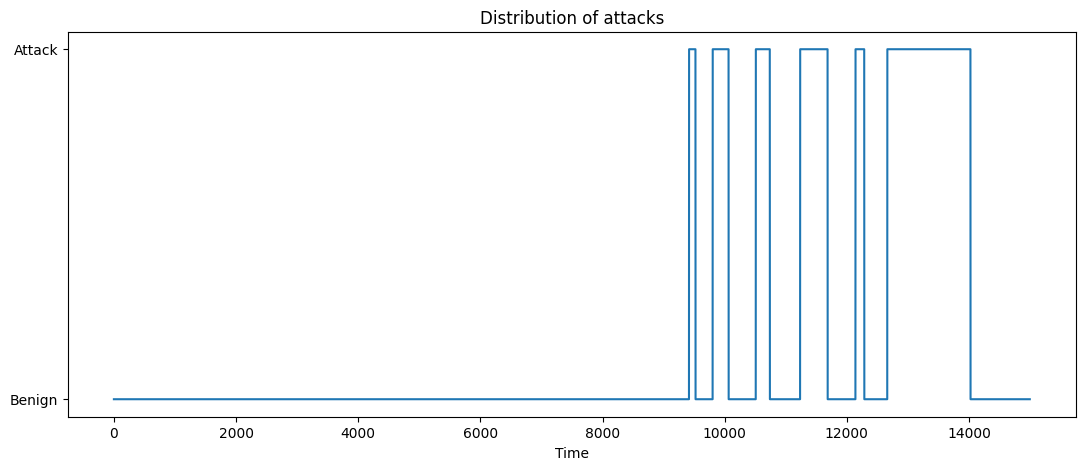

In [23]:
# plot labels
plt.figure(figsize=(13, 5))
plt.plot(labels)
plt.xlabel('Time')
plt.yticks([0, 1], ['Benign', 'Attack'])
plt.title("Distribution of attacks")

figure_path = os.path.join(dir, 'figures')
if not os.path.exists(figure_path):
  os.mkdir(figure_path)
plt.savefig(os.path.join(figure_path, 'attacks_distribution.png'))

Afin d'implémenter un LSTM il faut générer le dataset issue de nos série temporelles. Le but sera d'extraire plusieurs séquences d'une taille de séquence définie et de lui affecter un label. Si une séquence contient une valeur Label à 1 alors toute la séquence est labellisée comme étant à 1.

### LSTM avec fenetres glissantes seq2one

In [24]:
len_sequence = 180
len_start = len_sequence
len_end = len(labels) - len_sequence

X_hist, X_fut, y = [], [], []
for i in range(len_start, len_end):
    X_hist.append(features_scaled[i:i+len_sequence])
    X_fut.append(features_scaled[i+len_sequence])
    y.append(labels[i+len_sequence])


X_hist = np.array(X_hist)
X_fut = np.array(X_fut)
y = np.array(y)

print(f'X_hist shape: {X_hist.shape}')
print(f'X_fut shape: {X_fut.shape}')

X_hist shape: (14636, 180, 43)
X_fut shape: (14636, 43)


In [25]:
np.where(y == 1)[0][0]

9056

In [26]:
# keep 80% of the data for training and 20% for testing
# n_train = int(X_hist.shape[0] * 0.8)

# On entraine le modèle sur les données avant l'attaque
n_train = np.where(y == 1)[0][0] - 1


X_hist_train, X_hist_test = X_hist[:n_train], X_hist[n_train:]
X_fut_train, X_fut_test = X_fut[:n_train], X_fut[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

#shuffle data
shuffle_idx = np.random.permutation(n_train)
X_hist_train, X_fut_train = X_hist_train[shuffle_idx], X_fut_train[shuffle_idx]

In [27]:
print(f'Nombre de séquences d\'entraînement: {X_hist_train.shape[0]}')
print(f'Fenêtre de temps: {X_hist_train.shape[1]}')
print(f'Nombre de séquences de test: {X_hist_test.shape[0]}')

Nombre de séquences d'entraînement: 9055
Fenêtre de temps: 180
Nombre de séquences de test: 5581


In [28]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

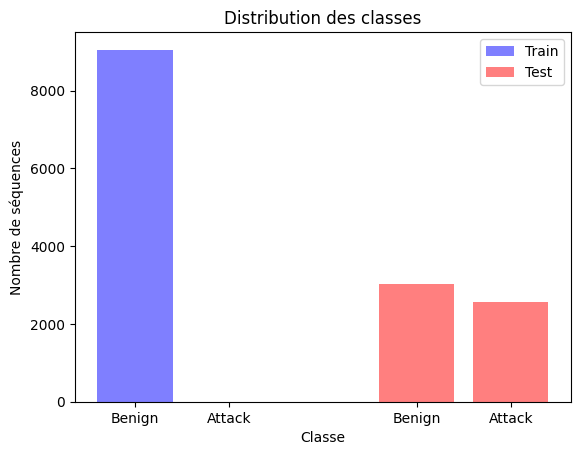

In [30]:
# plt.hist(y_train, bins=2, color='blue', alpha=0.5, label='Train')
# plt.hist(y_test, bins=2, color='red', alpha=0.5, label='Test')

plt.bar([0, 1], [len(y_train[y_train == 0]), len(y_train[y_train == 1])], color='blue', alpha=0.5, label='Train')
plt.bar([3, 4], [len(y_test[y_test == 0]), len(y_test[y_test == 1])], color='red', alpha=0.5, label='Test')
plt.title('Distribution des classes')
plt.xlabel('Classe')
plt.ylabel('Nombre de séquences')
plt.xticks([0, 1, 3, 4], ['Benign', 'Attack', 'Benign', 'Attack'])
plt.legend()

plt.savefig(os.path.join(figure_path, 'Distribution.png'), dpi=300)

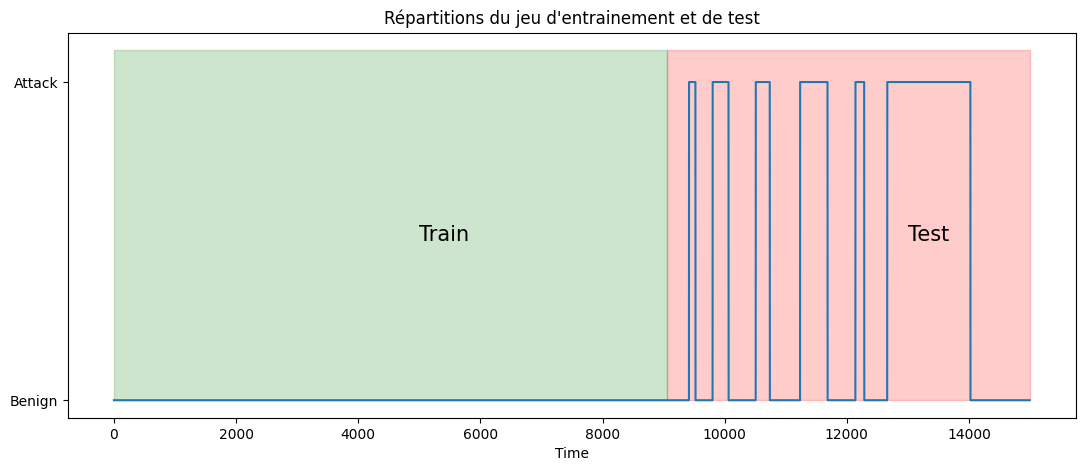

In [31]:
# plot labels
plt.figure(figsize=(13, 5))
plt.plot(labels)
plt.xlabel('Time')
plt.yticks([0, 1], ['Benign', 'Attack'])
plt.fill_between([n_train, len(labels)], 0, 1.1, color='red', alpha=0.2)
plt.fill_between([0, n_train-1], 0, 1.1, color='green', alpha=0.2)
plt.text(5000, 0.5, 'Train', fontsize=15)
plt.text(13000, 0.5, 'Test', fontsize=15)
plt.title("Répartitions du jeu d'entrainement et de test")

plt.savefig(os.path.join(figure_path, "Répartitions du jeu d'entrainement et de test.png"))

In [32]:
def build_model(nb_neurons, len_sequence, nb_features):
    model = tf.keras.Sequential([
        LSTM(nb_neurons, input_shape=(len_sequence, nb_features), return_sequences=True),
        Dropout(0.2),
        LSTM(nb_neurons, return_sequences=False),
        Dropout(0.2),
        Dense(nb_features, activation='sigmoid')
    ])

    return model

nb_features = X_hist_train.shape[2]

model = build_model(nb_neurons=64,
                    len_sequence=len_sequence,
                    nb_features=nb_features)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 64)           27648     
                                                                 
 dropout (Dropout)           (None, 180, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 43)                2795      
                                                                 
Total params: 63467 (247.92 KB)
Trainable params: 63467 (247.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.mean_squared_error
r2 = tf.keras.metrics.R2Score()
mse = tf.keras.metrics.MeanSquaredError()
metrics = [r2, mse]


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_hist_train,
                    y=X_fut_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=64,
                    verbose="auto")

Epoch 1/10
114/114 [==============================] - 21s 42ms/step - loss: 0.0388 - r2_score: -18495.8828 - mean_squared_error: 0.0388 - val_loss: 0.0095 - val_r2_score: -1902.0656 - val_mean_squared_error: 0.0095
Epoch 2/10
114/114 [==============================] - 3s 23ms/step - loss: 0.0099 - r2_score: -1724.3817 - mean_squared_error: 0.0099 - val_loss: 0.0045 - val_r2_score: -683.7928 - val_mean_squared_error: 0.0045
Epoch 3/10
114/114 [==============================] - 3s 25ms/step - loss: 0.0063 - r2_score: -993.6704 - mean_squared_error: 0.0063 - val_loss: 0.0031 - val_r2_score: -355.3937 - val_mean_squared_error: 0.0031
Epoch 4/10
114/114 [==============================] - 3s 27ms/step - loss: 0.0047 - r2_score: -600.8395 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_r2_score: -225.2377 - val_mean_squared_error: 0.0025
Epoch 5/10
114/114 [==============================] - 3s 28ms/step - loss: 0.0038 - r2_score: -425.9842 - mean_squared_error: 0.0038 - val_loss: 0.0022

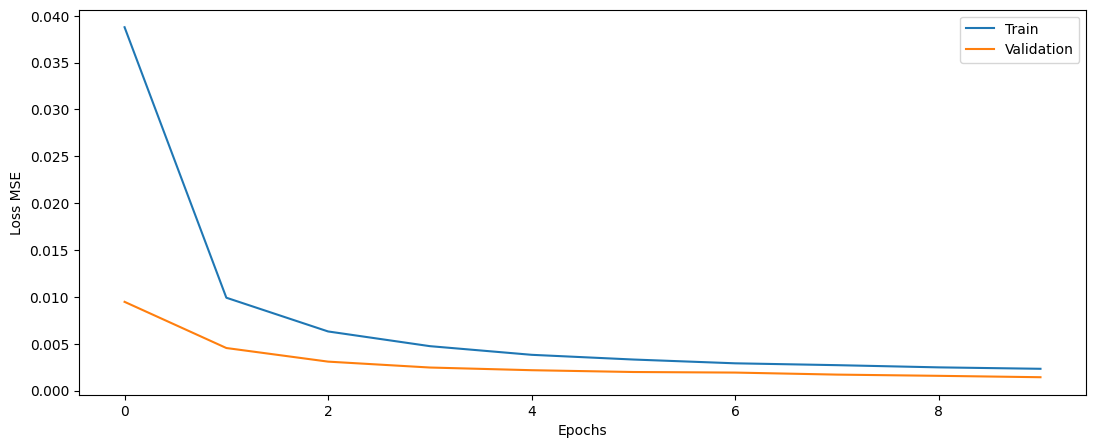

In [34]:
def plot_history(history):
    plt.figure(figsize=(13, 5))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss MSE')
    plt.legend()

plot_history(history)
plt.savefig(os.path.join(figure_path, 'history.png'))

In [35]:
def RMS_deviation(predicted, X_fut_test):
    rms = np.sqrt(np.mean(np.power((predicted - X_fut_test), 2), axis=1))
    return rms

dict_df = {col:i for i, col in enumerate(features.columns)}
predicted = model.predict(X_hist_test)
rms = RMS_deviation(predicted, X_fut_test)

175/175 [==============================] - 2s 8ms/step


Text(0.5, 0.98, 'Few examples Predicted vs True')

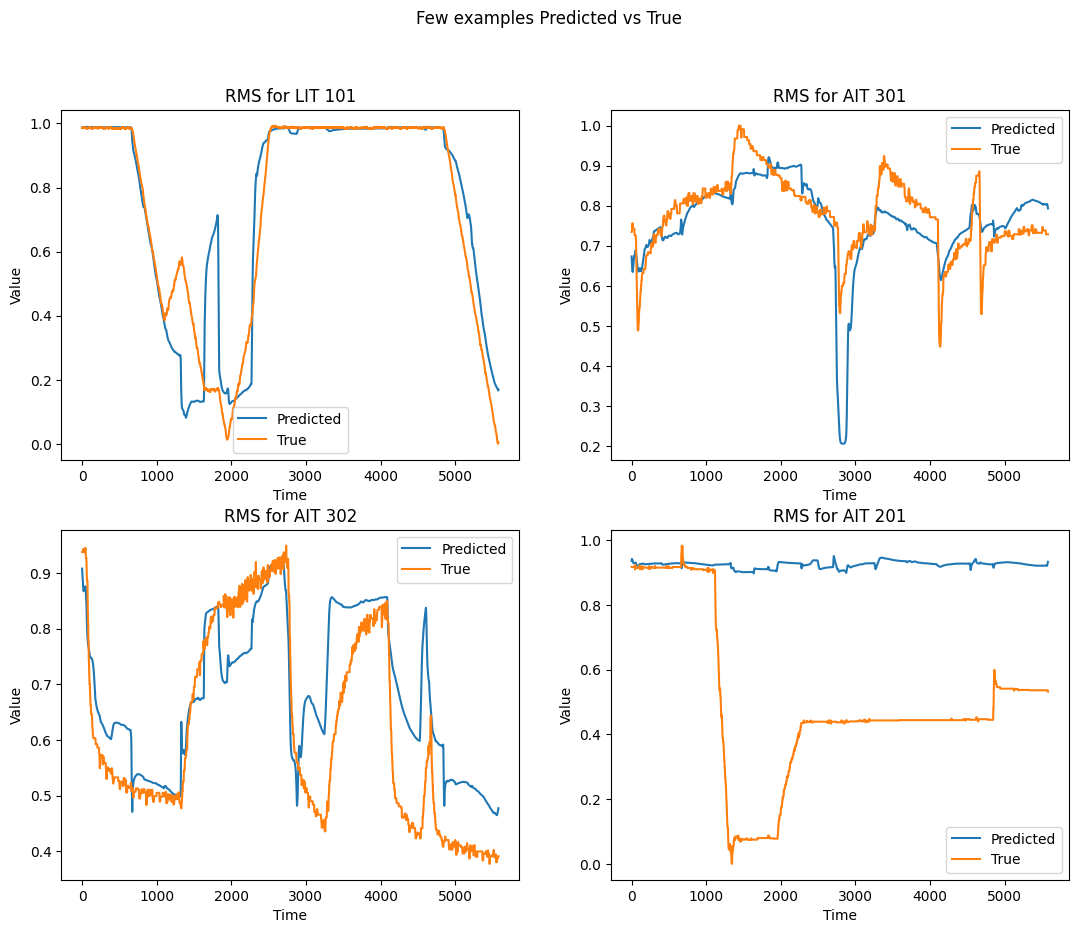

In [36]:
def rms_feature(rms, feature_name):
    feature = dict_df[feature_name]
    power = np.power((predicted[:, feature] - X_fut_test[:, feature]), 2)
    rms = np.sqrt(power)
    return rms


rms_lit = rms_feature(rms, 'LIT 101')
def plot_history_feature(feature_name):
    plt.plot(predicted[:, dict_df[feature_name]], label='Predicted')
    plt.plot(X_fut_test[:, dict_df[feature_name]], label='True')
    # plt.plot(rms_lit, label='RMS')
    plt.title("RMS for {}".format(feature_name))
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.figure(figsize=(13, 10))
plt.subplot(2, 2, 1)
plot_history_feature('LIT 101')
plt.subplot(2, 2, 2)
plot_history_feature('AIT 301')
plt.subplot(2, 2, 3)
plot_history_feature('AIT 302')
plt.subplot(2, 2, 4)
plot_history_feature('AIT 201')
plt.suptitle('Few examples Predicted vs True')

In [37]:
attack = cleaned_df["Attack"][n_train+len_start*2:].reset_index(drop=True)
attacks = attack.unique()
attacks

array(['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
      dtype=object)

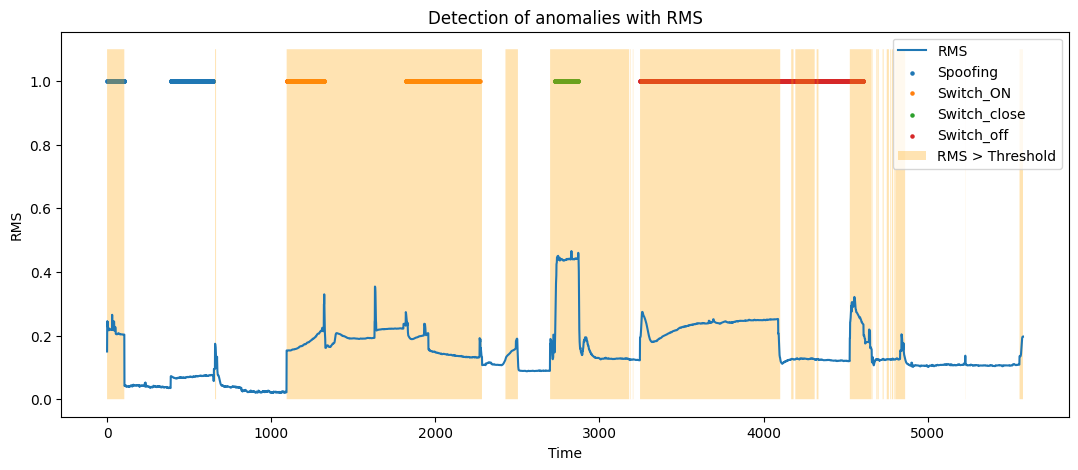

In [38]:
threshold = 0.125

plt.figure(figsize=(13, 5))
plt.plot(rms, label='RMS')
# plt.scatter(np.where(y_test == 1), y_test[y_test == 1], color='red', label='Attack', s=5)
for i in range(1, len(attacks)):
    bool1 = attack == attacks[i]
    idx = attack[bool1].index
    plt.scatter(idx, np.ones(shape=len(idx)), label=attacks[i], s=5)

plt.fill_between(np.arange(len(rms)), rms, 0, where=(rms > threshold), facecolor='orange', alpha=0.3, label='RMS > Threshold')
plt.fill_between(np.arange(len(rms)), rms, 1.1, where=(rms > threshold), facecolor='orange', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('RMS')
plt.title('Detection of anomalies with RMS')
plt.legend()

plt.savefig(os.path.join(figure_path, 'Detection of anomalies with RMS Threshold 0.125.png'))

In [39]:
# Metrics
tp = np.where((rms >= threshold) & (y_test == 1))[0]
fp = np.where((rms >= threshold) & (y_test == 0))[0]
tn = np.where((rms < threshold) & (y_test == 0))[0]
fn = np.where((rms < threshold) & (y_test == 1))[0]


recall = len(tp) / (len(tp) + len(fn))
precision = len(tp) / (len(tp) + len(fp))
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (len(tp) + len(tn)) / (len(tp) + len(tn) + len(fp) + len(fn))


print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score: {f1}')
print(f'Accuracy: {accuracy}')

Recall: 0.7892675283979632
Precision: 0.6390738978750397
F1 score: 0.7062740974412899
Accuracy: 0.6996953950904856


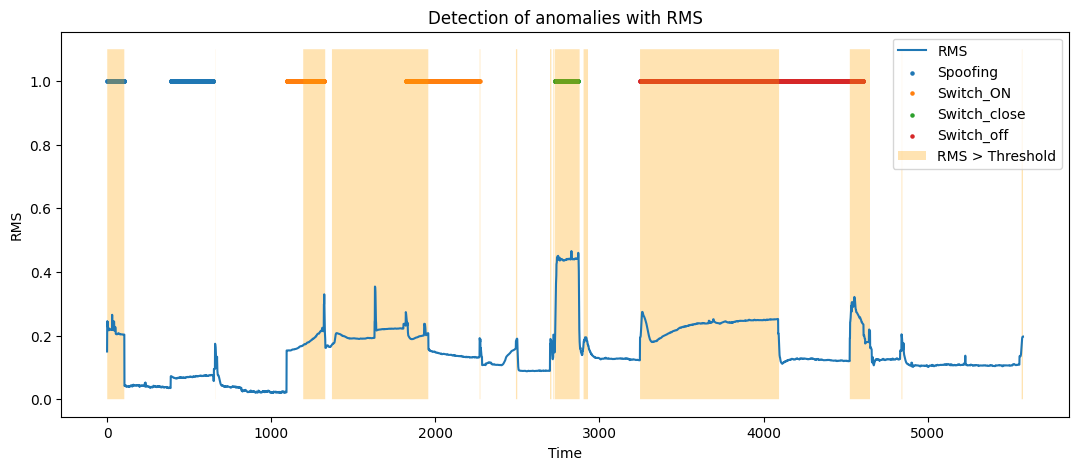

In [42]:
threshold = 0.17

plt.figure(figsize=(13, 5))
plt.plot(rms, label='RMS')
# plt.scatter(np.where(y_test == 1), y_test[y_test == 1], color='red', label='Attack', s=5)
for i in range(1, len(attacks)):
    bool1 = attack == attacks[i]
    idx = attack[bool1].index
    plt.scatter(idx, np.ones(shape=len(idx)), label=attacks[i], s=5)

plt.fill_between(np.arange(len(rms)), rms, 0, where=(rms > threshold), facecolor='orange', alpha=0.3, label='RMS > Threshold')
plt.fill_between(np.arange(len(rms)), rms, 1.1, where=(rms > threshold), facecolor='orange', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('RMS')
plt.title('Detection of anomalies with RMS')
plt.legend()

plt.savefig(os.path.join(figure_path, 'Detection of anomalies with RMS Threshold 0.17.png'))

In [43]:
# Metrics
tp = np.where((rms >= threshold) & (y_test == 1))[0]
fp = np.where((rms >= threshold) & (y_test == 0))[0]
tn = np.where((rms < threshold) & (y_test == 0))[0]
fn = np.where((rms < threshold) & (y_test == 1))[0]


recall = len(tp) / (len(tp) + len(fn))
precision = len(tp) / (len(tp) + len(fp))
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (len(tp) + len(tn)) / (len(tp) + len(tn) + len(fp) + len(fn))


print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score: {f1}')
print(f'Accuracy: {accuracy}')

Recall: 0.5660007833920877
Precision: 0.7121734844751109
F1 score: 0.6307289393278044
Accuracy: 0.6968285253538792


In [45]:
# Plot RMS for each feature

def rms_all():
    power = np.power((predicted - X_fut_test), 2)
    rms = np.sqrt(power)
    return rms

rms_all = rms_all()
rms_all.shape

def plot_rms_feature(list, title="", save=False):
    plt.figure(figsize=(13, 5))
    plt.title(title)
    for rms in list:
        plt.plot(rms_all[rms, :], label=f"{rms}")
    plt.xlabel('features')
    plt.ylabel('RMS')
    plt.ylim(0, 1)
    plt.legend()
    plt.xticks(np.arange(len(features.columns)), features.columns, rotation=90)

    if save:
        plt.savefig(os.path.join(figure_path, f'{title}.png'), dpi=300)

    plt.show()

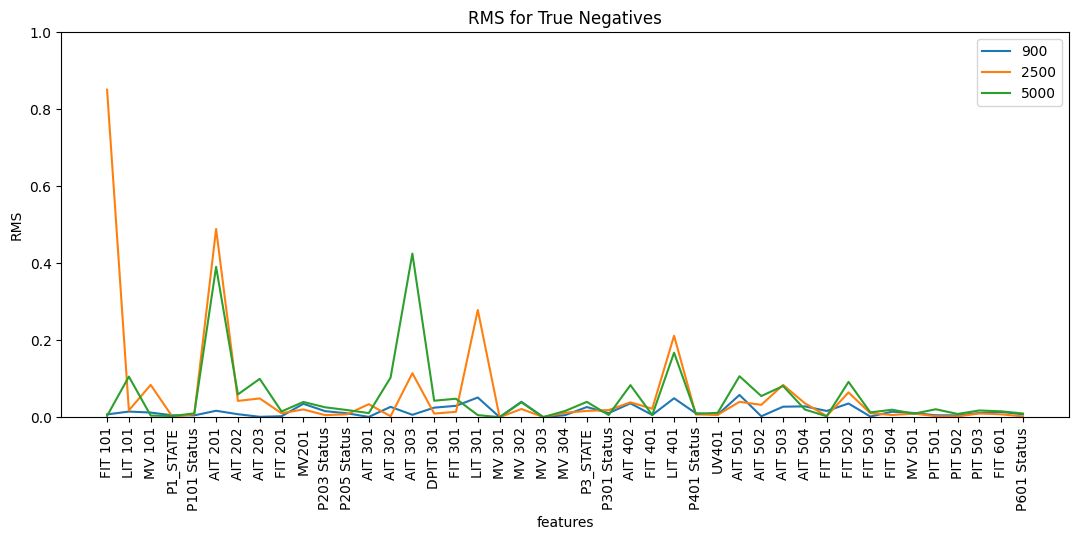

In [46]:
assert(np.isin(900, tn))
assert(np.isin(2500, tn))
assert(np.isin(5000, tn))


list_tn = [900, 2500, 5000]
plot_rms_feature(list_tn, title="RMS for True Negatives", save=True)

Les vrais négatifs se manifestent lorsqu'un événement est correctement identifié comme non-anomal. Ces résultats sont généralement caractérisés par des valeurs de RMS (Root Mean Square) relativement basses pour chaque capteur, indiquant que les séquences prédites par le modèle LSTM correspondent étroitement aux données réelles. Cela signifie que le comportement observé suit les patterns habituels que le modèle a appris pendant la phase d'entraînement, et donc, il n'y a pas de signaux d'alerte indiquant une activité malveillante ou anormale.

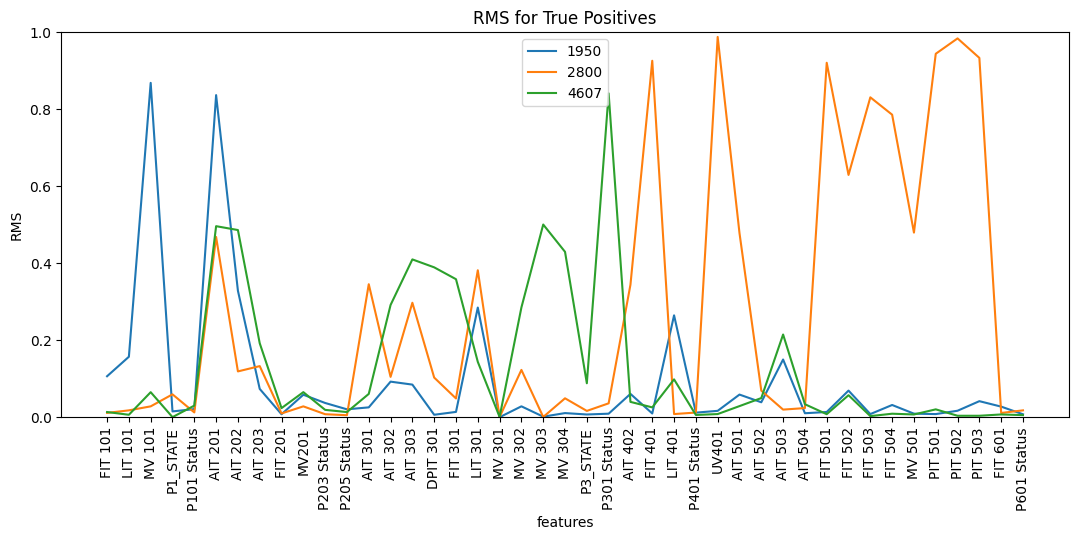

In [47]:
assert(np.isin(4607, tp))
assert(np.isin(2800, tp))
assert(np.isin(1950, tp))

list_tp = [1950, 2800, 4607, ]
plot_rms_feature(list_tp, title="RMS for True Positives", save=True)

À l'inverse, les vrais positifs surviennent lorsque le modèle détecte correctement une anomalie. Ces instances sont souvent accompagnées de valeurs de RMS élevées pour certains capteurs, suggérant que la prédiction du modèle diffère significativement de la réalité. La cause de cette divergence est généralement attribuée à l'écart entre les patterns de signal que le LSTM a appris à reconnaître et les séquences de données terrain, qui s'éloignent nettement de ces patterns attendus. En d'autres termes, lorsque le modèle rencontre des données qui diffèrent radicalement de ce qu'il a été entraîné à prévoir, la déviation résultante dans les valeurs RMS est un indicateur que quelque chose d'inhabituel se produit, possiblement une attaque.

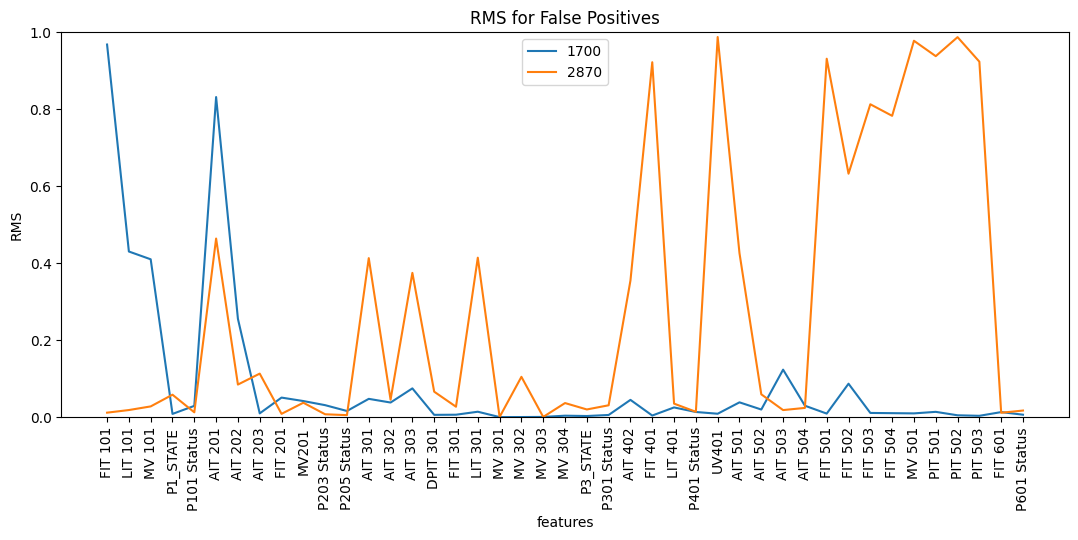

In [48]:
assert(np.isin(1700, fp))
assert(np.isin(2870, fp))

list_fp = [1700, 2870]
plot_rms_feature(list_fp, title="RMS for False Positives", save=True)

Les faux positifs dans le contexte de la détection d'anomalies en cybersécurité représentent des événements où le modèle prédit à tort une attaque ou une anomalie. Ces incidents peuvent se produire même après la cessation d'une attaque réelle, lorsqu'un modèle prédictif tel qu'un LSTM continue d'indiquer des erreurs significatives dans les données de capteur.

Pour comprendre ce phénomène, il est important de considérer l'impact temporel qu'une attaque peut avoir sur le comportement des capteurs et, par conséquent, sur la prédiction du modèle. Durant une attaque, il est probable que les schémas de données des capteurs soient perturbés, ce qui entraîne une prédiction erronée de la part du LSTM qui a été entraîné sur des données représentant un comportement normal. Une fois l'attaque terminée, bien que les capteurs puissent rapidement revenir à leurs rythmes périodiques habituels, le modèle prédictif peut encore souffrir des répercussions de cette perturbation.

L'effet persistant de l'attaque sur les prédictions du modèle se manifeste sous la forme de valeurs RMS élevées, qui suggèrent une continuation de l'anomalie même en l'absence d'une activité malveillante réelle. Cela peut être dû au fait que le modèle, influencé par les récentes données anormales, anticipe à tort des comportements similaires dans les prédictions futures. En d'autres termes, l'attaque a créé une sorte de "rémanence" dans les prédictions du modèle qui se manifeste par des erreurs prolongées même après le retour à la normale.

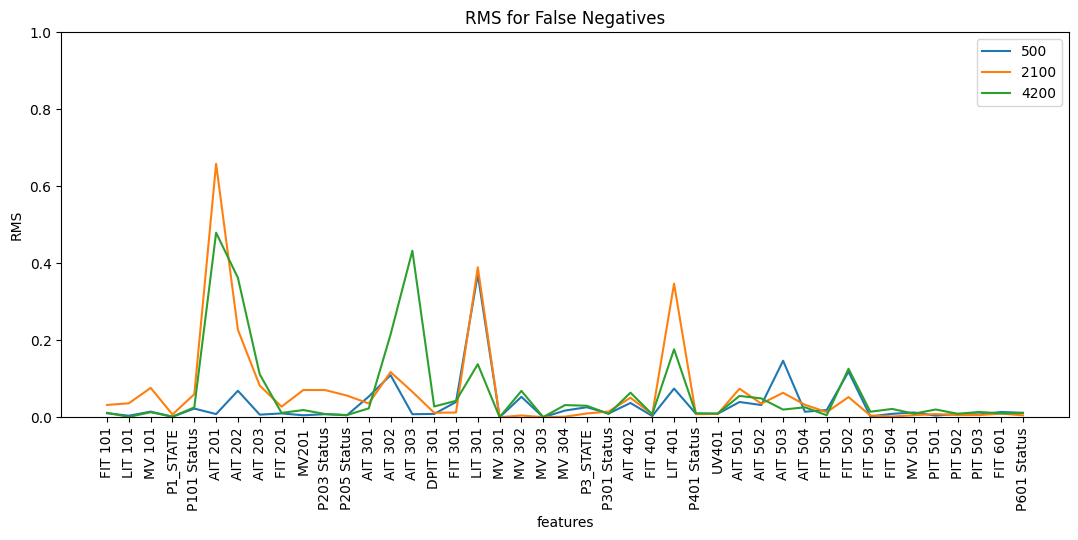

In [49]:
assert(np.isin(500, fn))
assert(np.isin(2100, fn))
assert(np.isin(4200, fn))

list_fn = [500, 2100, 4200]
plot_rms_feature(list_fn, title="RMS for False Negatives", save=True)

Les faux négatifs dans le contexte de la détection d'anomalies, spécialement en cybersécurité, sont des instances où le système échoue à identifier et signaler une attaque réelle. Cela signifie qu'une activité malveillante s'est produite, mais les valeurs relevées par les capteurs n'ont pas dépassé le seuil RMS établi pour déclencher une alerte. Ce scénario est particulièrement problématique car il permet aux attaques de réussir sans être détectées, laissant potentiellement les systèmes et les données vulnérables à des dommages ou à des exfiltrations.

L'un des moyens de remédier à ce problème est d'augmenter le seuil de détection RMS. En théorie, cela permettrait de capter des anomalies plus subtiles qui pourraient autrement passer inaperçues. Cependant, cette approche a un coût significatif en termes de précision du modèle. En abaissant le critère de détection, le modèle commence à générer davantage de faux positifs, c'est-à-dire des alertes signalant des anomalies là où il n'y en a pas. Cela peut conduire à une surcharge pour les équipes de sécurité qui doivent examiner un plus grand nombre d'alertes, dont la plupart pourraient s'avérer être des non-issues.

## Outlier detection with Isolation forest.

Isolation forest Algorithm is applied on categorical data with precising an `outliers_fraction` which represent the outlier rate in our dataset. To do so we just need to get the total count of attacks (labelled 1 data) and divide it by the total count.

With `get_list_of_if_outliers` implemented in previous practical sessions, we apply Isolation forest algorithm on categroical data. Then we will retrieve outliers indexes.

In [50]:
outlier_fraction = (full_df['Label'] == 1).sum() / len(full_df)
# attacked_columns = ['FIT 401', 'LIT 301', 'P601 Status', 'MV201', 'P101 Status', 'MV 501', 'P301 Status']
if_outlier_indexes = get_list_of_if_outliers(full_df.drop(columns=['Date', 'Attack', 'Label']), outlier_fraction, seed=35)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Let's compute accuracy by counting predicted outliers which are real outliers.

In [51]:
if_outliers = np.zeros(len(full_df))
if_outliers[if_outlier_indexes] = 1
full_df['if_outliers'] = if_outliers

attack_if_outliers = full_df[(full_df['if_outliers'] == 1) & (full_df['Label'] == 1)]
if_outliers_matches = len(attack_if_outliers)
print(f'{if_outliers_matches} outliers found with Isolation Forest are labeled as attacks')

877 outliers found with Isolation Forest are labeled as attacks


Then we compute F1 Score

In [52]:
print(classification_report(full_df['if_outliers'], full_df['Label']))

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     12443
         1.0       0.34      0.34      0.34      2553

    accuracy                           0.78     14996
   macro avg       0.60      0.60      0.60     14996
weighted avg       0.78      0.78      0.78     14996



Let's now display confusion matrix.

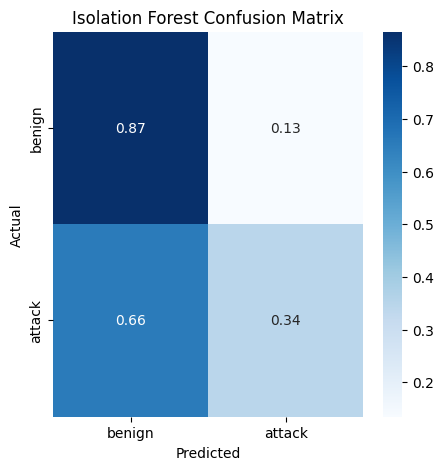

In [53]:
import seaborn as sns

def confusion_matrix_plot(y_true, y_pred, title, list_labels = ['benign', 'attack']):
  cm = confusion_matrix(y_true, y_pred, normalize='true')
  plt.figure(figsize=(5, 5))

  sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=list_labels, yticklabels=list_labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title)
  plt.show()

confusion_matrix_plot(full_df['if_outliers'], full_df['Label'], 'Isolation Forest Confusion Matrix')

From the results, we can see that the Isolation Forest algorithm is not much sensitive nor precise when detecting outliers.

In [54]:
full_df.to_csv(os.path.join(dir,'data/clean_swat.csv'))

## Outlier detection with LocalOutlierFactor

In [55]:
local_factor_outliers_indices = get_list_of_lof_outliers(full_df.drop(columns=['Date', 'Attack', 'Label']), outlier_fraction)

lof_outliers = np.zeros(len(full_df))
lof_outliers[local_factor_outliers_indices] = 1
full_df['lof_outliers'] = lof_outliers

In [56]:
attack_lof_outliers = full_df[(full_df['lof_outliers'] == 1) & (full_df['Label'] == 1)]
lof_outliers_matches = len(attack_lof_outliers)
print(f'{lof_outliers_matches} outliers found with Local Outlier Factor are labeled as attacks')

606 outliers found with Local Outlier Factor are labeled as attacks


In [57]:
print(classification_report(full_df['lof_outliers'], full_df['Label']))

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84     12443
         1.0       0.24      0.24      0.24      2553

    accuracy                           0.74     14996
   macro avg       0.54      0.54      0.54     14996
weighted avg       0.74      0.74      0.74     14996



Now we display the confusion matrix.

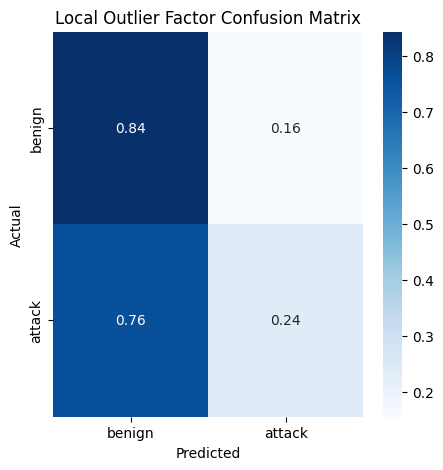

In [58]:
confusion_matrix_plot(full_df['lof_outliers'], full_df['Label'], 'Local Outlier Factor Confusion Matrix')

In comparison, as we can see from this report, LocalOutlierFactor algorithm is even less sensitive than the Isolation Forest algorithm.\
We can assume that an unsupervised algorithm may not be the best choice for this dataset.

## Combining detected outliers

We can now try to combine the results of the two algorithms to see if we can get better results.

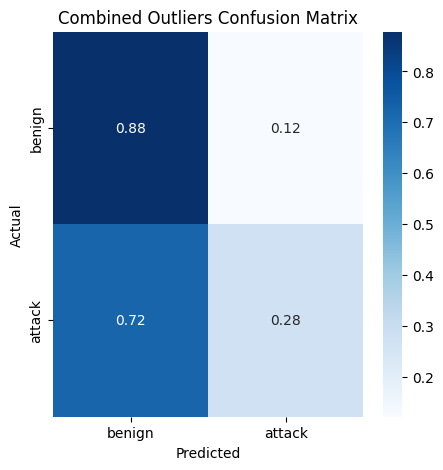

In [59]:
combined_outliers = np.zeros(len(full_df))
combined_outliers[if_outlier_indexes] = 1
combined_outliers[local_factor_outliers_indices] = 1
full_df['combined_outliers'] = combined_outliers

confusion_matrix_plot(combined_outliers, full_df['Label'], 'Combined Outliers Confusion Matrix')

We can deduce from this confusion matrix that there is a hypersensibily to begnin data, as the begnin cells present an elevated recall.

In [60]:
print(classification_report(full_df['combined_outliers'], full_df['Label']))

              precision    recall  f1-score   support

         0.0       0.73      0.88      0.79     10282
         1.0       0.51      0.28      0.36      4714

    accuracy                           0.69     14996
   macro avg       0.62      0.58      0.58     14996
weighted avg       0.66      0.69      0.66     14996



### 3D representation of combined outliers

In [61]:
def plot_3D_scatter(data: pd.DataFrame, outliers: pd.Series, dataset_name: str) -> None:
    """
    Show 3D plot of the input data.

    Args:
        data (pd.DataFrame): input data
    """
    layout = go.Layout(scene={"aspectmode": "cube"})
    layout['scene'].update(xaxis_title='X', yaxis_title='Y', zaxis_title='Z')
    layout['title'] = f"{dataset_name} Dataset distribution"
    fig = go.Figure(data=[go.Scatter3d(
        x=data['X'],
        y=data['Y'],
        z=data['Z'],
        mode='markers',
        text=data['Attack'],
        marker=dict(
            size=2,
            color=outliers,
            colorscale='Viridis',
            opacity=0.5
        )
    )], layout=layout)
    py.iplot(fig, show_link=False)

def get_outlier_color(val: int) -> str:
    return 'red' if val == 1 else 'black'

X_reduced_df['Detected_Outliers'] = full_df['combined_outliers'].apply(get_outlier_color)
plot_3D_scatter(X_reduced_df, X_reduced_df['Detected_Outliers'], "SWaT")

From what we can observe, the combination of the two algorithms does not seem to be profitable here. Indeed, we observe a lot of false positives but also false negatives. The problem is that the sensibilities of both algorithms are not tuned to the true outliers. The detected outliers are not very precise either to determine the begnign samples.

## Binary classification

Let us now focus on supervised learning algorithms, starting with binary classification. The goal is simple, we want to be able to classify the data into two categories: benign or attack.

### Data preparation

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

First of all, we need to prepare our data. We will use the same data as for the unsupervised algorithms. The categorical data will be encoded with one-hot encoding, and the NaN values will be replaced through a mean imputation method.

In [63]:
seed: int = 42

n_attacks = full_df[full_df['Label'] == 1].shape[0]
df_begnin = full_df[full_df['Label'] == 0].sample(n_attacks, random_state=seed)
df_attacks = full_df[full_df['Label'] == 1]
df_sampled = pd.concat([df_begnin, df_attacks])

one_hot_encoded_df = get_one_hot_encoded_dataframe(df_sampled.drop(columns=['Date', 'Attack', 'Label', 'if_outliers', 'lof_outliers', 'combined_outliers']))
no_nan_df = remove_nan_through_mean_imputation(one_hot_encoded_df)

X = no_nan_df.to_numpy()
y = df_sampled['Label'].to_numpy()

Let us plot the labels of our truncated dataset.

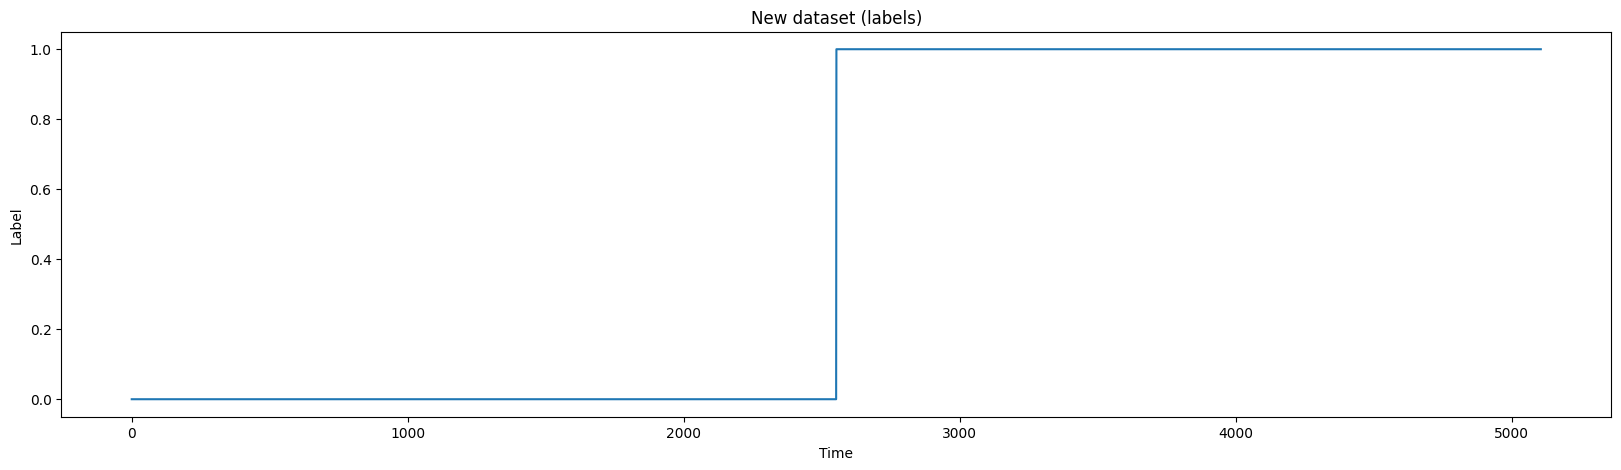

In [64]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(y)
ax.set_xlabel('Time')
ax.set_ylabel('Label')
ax.set_title('New dataset (labels)')
plt.show()

### Methodology

For each supervised classification algorithm, we will use the same methodology:

* Train the model by suffling the training data
* Train the model by leaving the training data as it is
* Train the model with cross-validation

The idea behind this comparative approach is to see how the model perform with various inter-class distributions.

In [65]:
def plot_feature_importance(model, orignal_df: pd.DataFrame):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    sorted_idx = sorted_idx[-10:]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(20, 5))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, orignal_df.columns[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

def plot_labels(train, test):
    fig, ax = plt.subplots(2, 1, figsize=(20, 5))
    ax[0].plot(train[::10])
    ax[1].plot(test[::10], color='orange')
    fig.legend(['Train', 'Test'])
    fig.suptitle('Labels (Train/Test)')
    plt.show()

### Cross Validation function

In [66]:
def cross_validate_model(X, y, model_gen, model_name, tscv) -> pd.DataFrame:
    res_total = pd.DataFrame()
    n = 0
    auprc_total = 0
    for (train_index, test_index) in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = model_gen()
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        res = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=0))
        try:
            auprc = average_precision_score(y_train, y_train_pred, average='weighted')
            n += 1
            auprc_total += auprc
        except ValueError:
            print(f'auprc_score failed for {model_name}')
            auprc = np.nan

        res_total = pd.concat([res_total, res[['weighted avg']]], axis=1)

    res_total = res_total.mean(axis=1).to_frame().T.drop(columns=['support'])
    res_total.index = [model_name]
    if n > 0:
        res_total['auprc_train'] = [auprc_total / n]

    return res_total

### Random Forest Classifier

In [67]:
def gen_random_forest() -> RandomForestClassifier:
    return RandomForestClassifier(
        n_estimators=256,
        max_depth=4,
        max_features='sqrt',
        random_state=seed
    )

#### Training with shuffled data

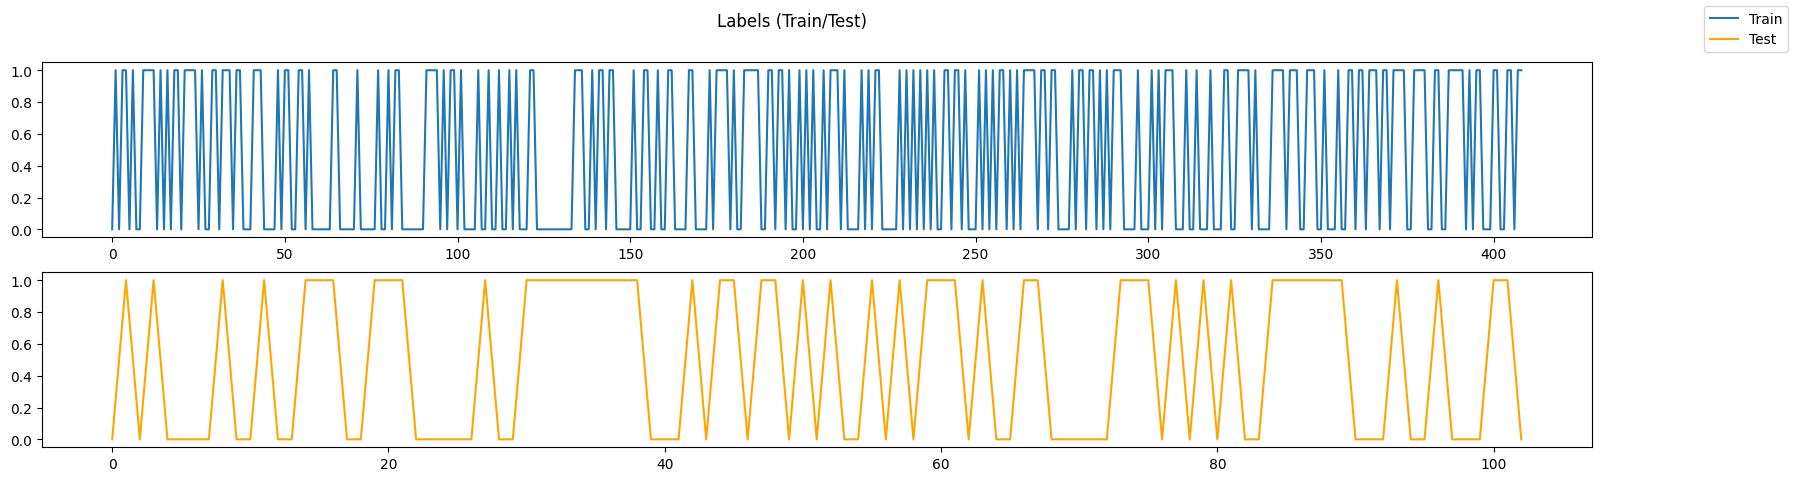

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
plot_labels(y_train, y_test)

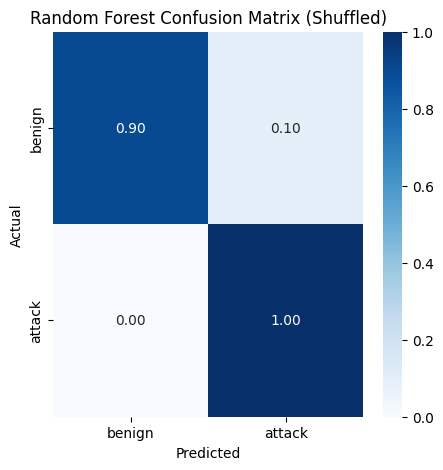

In [69]:
random_forest = gen_random_forest()
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
confusion_matrix_plot(y_test, y_pred, 'Random Forest Confusion Matrix (Shuffled)')

In [70]:
print("AUPRC: ", average_precision_score(y_test, y_pred, average='weighted'))

AUPRC:  0.9074733096085409


##### Feature importance

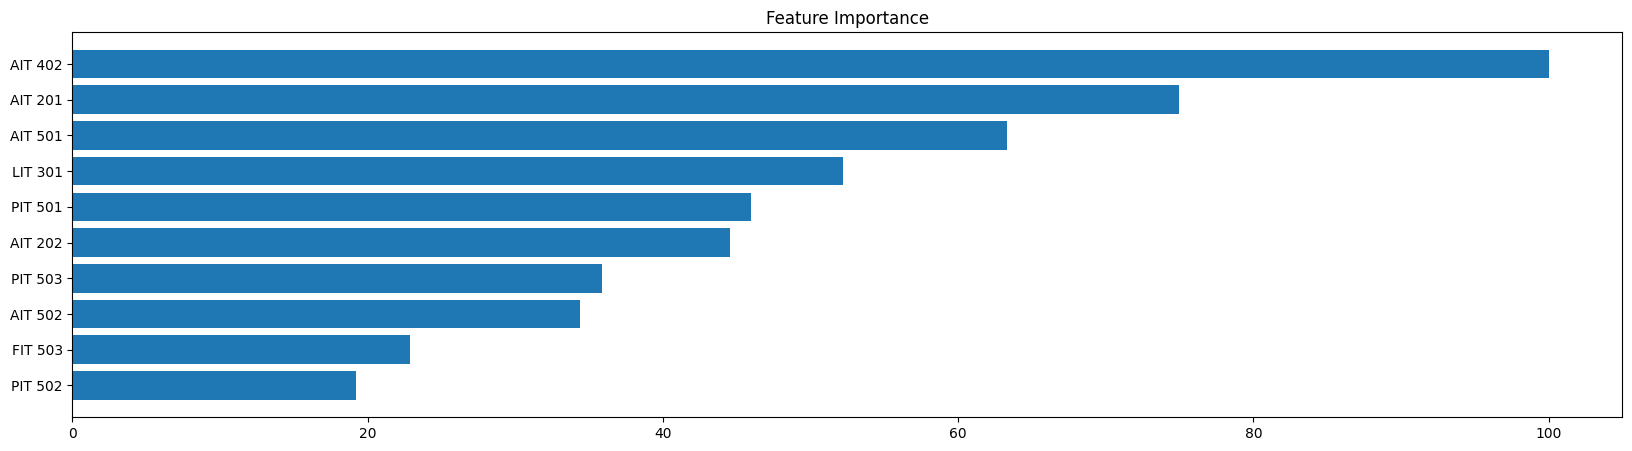

In [71]:
plot_feature_importance(random_forest, no_nan_df)

In [72]:
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

def plot_pca_with_predictions(X_test, y_test, y_pred):
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_test)
    fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]
    fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
    trace1 = go.Scatter3d(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        z=X_pca[:, 2],
        mode='markers',
        marker=dict(color='green', size=4),
        name='Bonnes Prédictions'
    )
    trace2 = go.Scatter3d(
        x=X_pca[fp_indices, 0],
        y=X_pca[fp_indices, 1],
        z=X_pca[fp_indices, 2],
        mode='markers',
        marker=dict(color='black', size=4),
        name='Faux Positifs'
    )

    trace3 = go.Scatter3d(
        x=X_pca[fn_indices, 0],
        y=X_pca[fn_indices, 1],
        z=X_pca[fn_indices, 2],
        mode='markers',
        marker=dict(color='red', size=4),  # Faux négatifs en rouge
        name='Faux Négatifs'
    )

    layout = go.Layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    fig.show()


plot_pca_with_predictions(X_test, y_test, y_pred)


#### Training with non-shuffled data

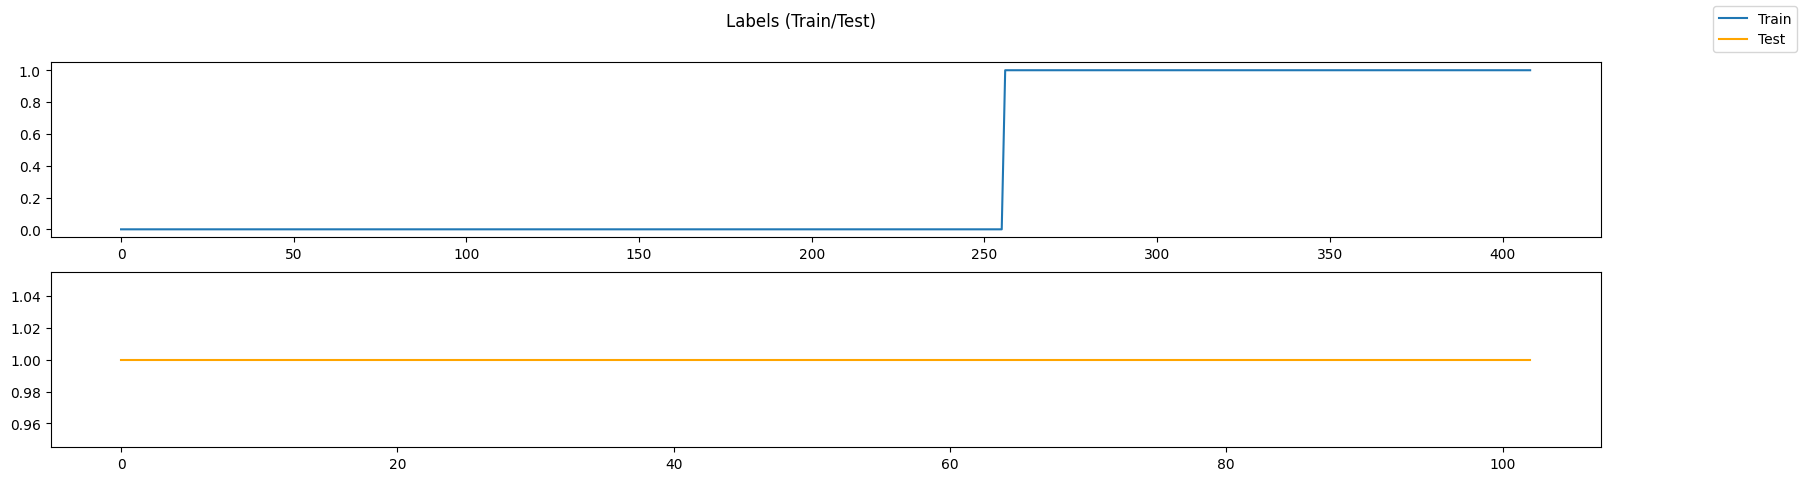

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
plot_labels(y_train, y_test)

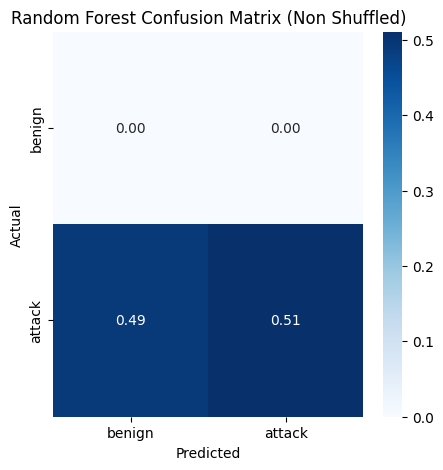

In [74]:
random_forest = gen_random_forest()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
confusion_matrix_plot(y_test, y_pred, 'Random Forest Confusion Matrix (Non Shuffled)')

##### Feature importance

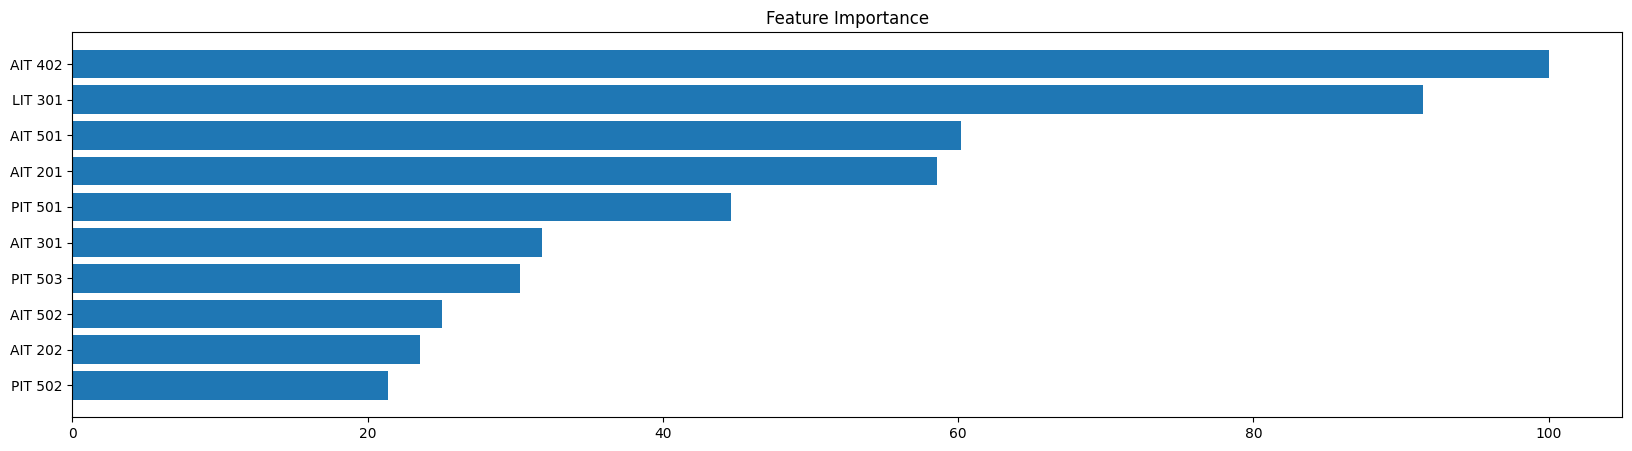

In [75]:
plot_feature_importance(random_forest, no_nan_df)

In [76]:
plot_pca_with_predictions(X_test, y_test, y_pred)

#### Cross-validation

In [77]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=int(0.2* X.shape[0] // n_splits))

cross_validate_model(X, y, gen_random_forest, 'Random Forest', tscv)

precision    recall  f1-score  auprc_train
Random Forest        1.0  0.830392  0.900246      0.96819

### Decision Tree Classifier

#### Training with shuffled data

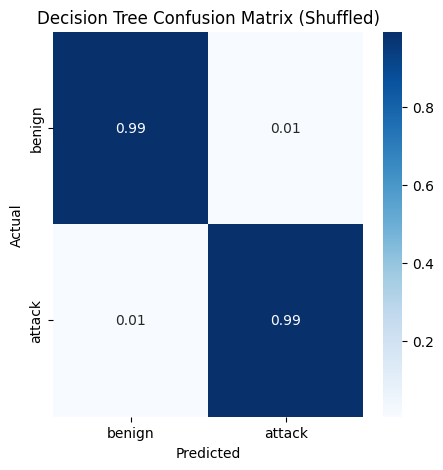

In [78]:
def gen_decision_tree() -> DecisionTreeClassifier:
    return DecisionTreeClassifier(
        max_depth=9,
        max_features='sqrt',
        random_state=seed
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
decision_tree = gen_decision_tree()
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
confusion_matrix_plot(y_test, y_pred, 'Decision Tree Confusion Matrix (Shuffled)')

In [79]:
print("AUPRC: ", average_precision_score(y_test, y_pred, average='weighted'))

AUPRC:  0.9894295055801295


##### Feature importance

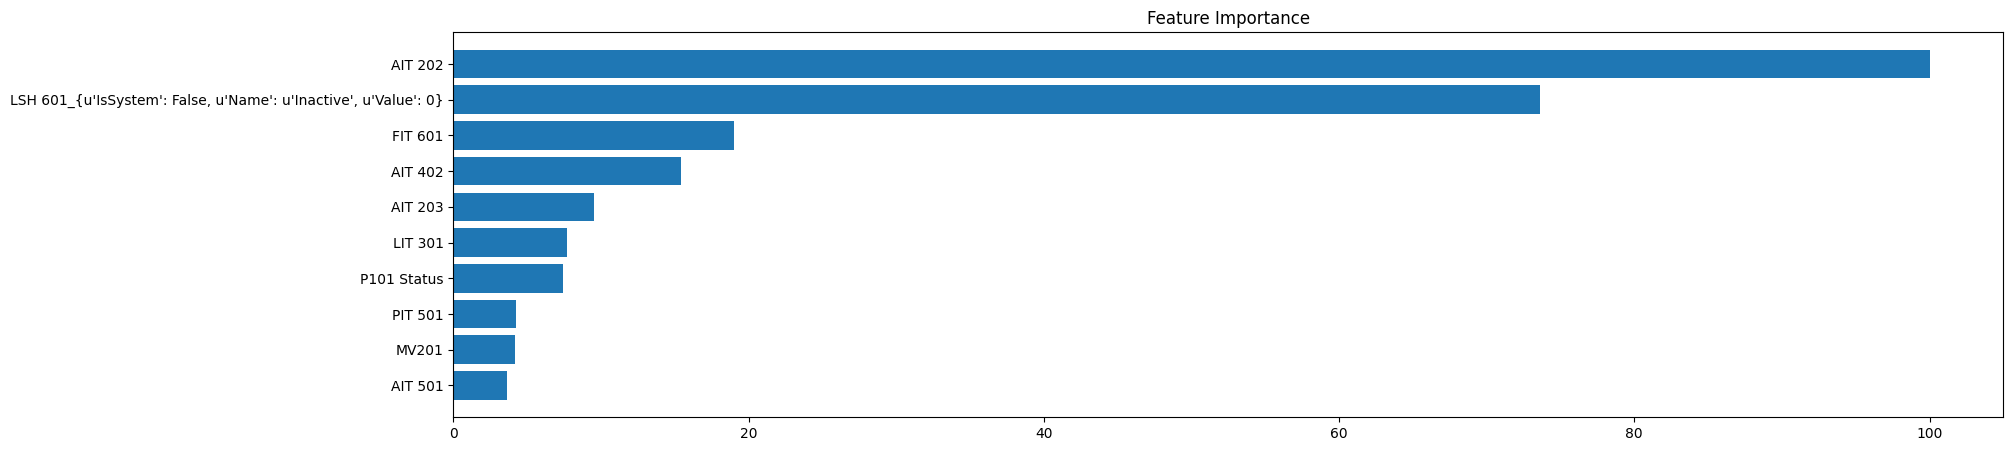

In [80]:
plot_feature_importance(decision_tree, no_nan_df)

In [81]:
plot_pca_with_predictions(X_test, y_test, y_pred)

#### Training with non-shuffled data

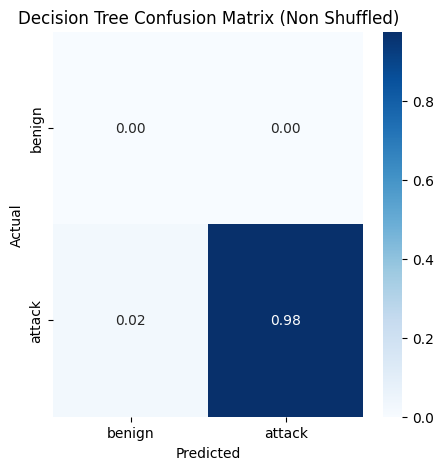

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
decision_tree = gen_decision_tree()
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
confusion_matrix_plot(y_test, y_pred, 'Decision Tree Confusion Matrix (Non Shuffled)')

##### Feature importance

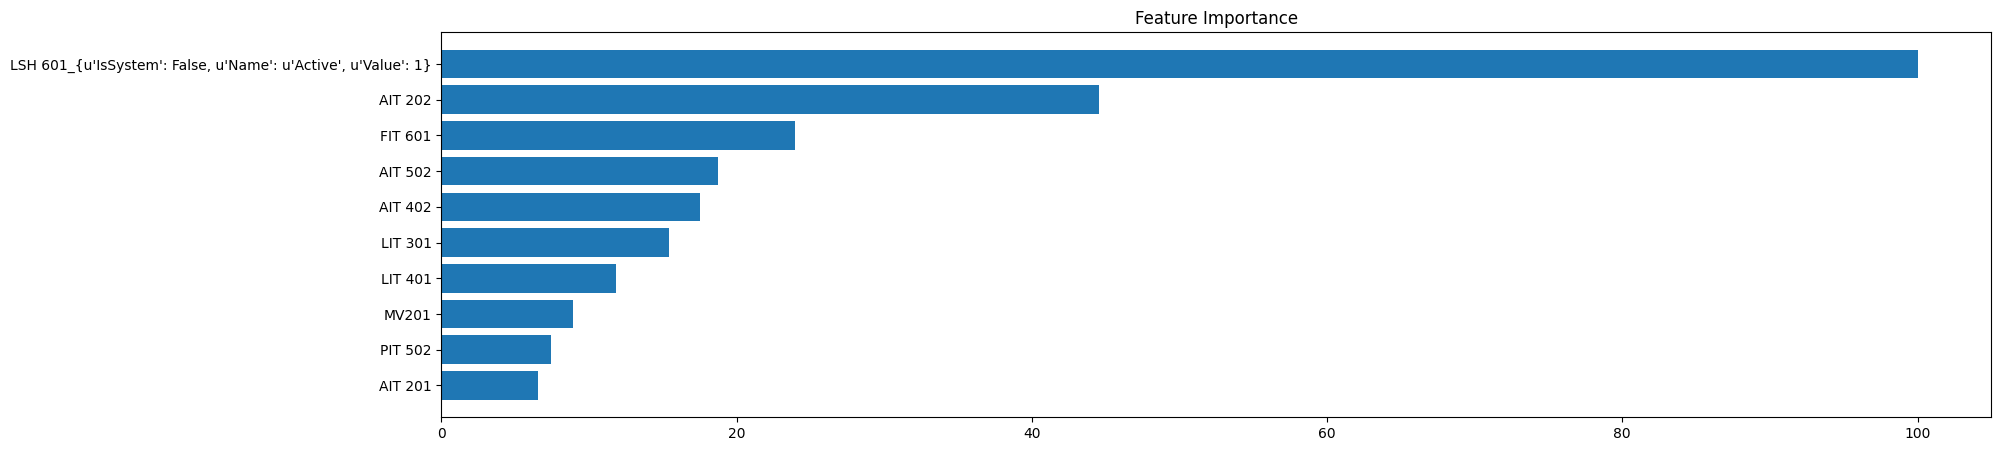

In [83]:
plot_feature_importance(decision_tree, no_nan_df)

In [84]:
plot_pca_with_predictions(X_test, y_test, y_pred)

#### Cross-validation

In [85]:
cross_validate_model(X, y, gen_decision_tree, 'Decision Tree', tscv)

precision   recall  f1-score  auprc_train
Decision Tree        1.0  0.82451  0.885547      0.99527

### XGBoost Classifier

#### Training with shuffled data

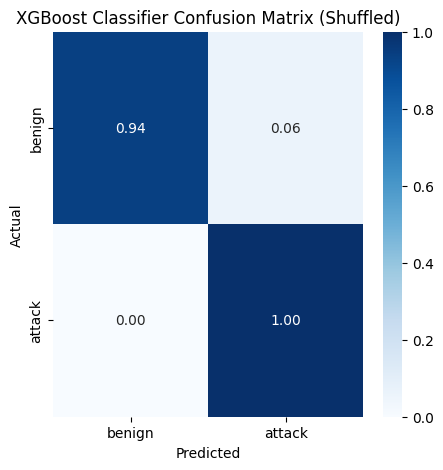

In [86]:
def gen_XGBoostClassifier() -> XGBClassifier:
    return XGBClassifier(
        n_estimators=400,
        max_depth=2,
        learning_rate=1e-2,
        random_state=seed
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
xgboost = gen_XGBoostClassifier()
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)
confusion_matrix_plot(y_test, y_pred, 'XGBoost Classifier Confusion Matrix (Shuffled)')

In [87]:
print("AUPRC: ", average_precision_score(y_test, y_pred, average='weighted'))

AUPRC:  0.9415094339622642


##### Feature importance

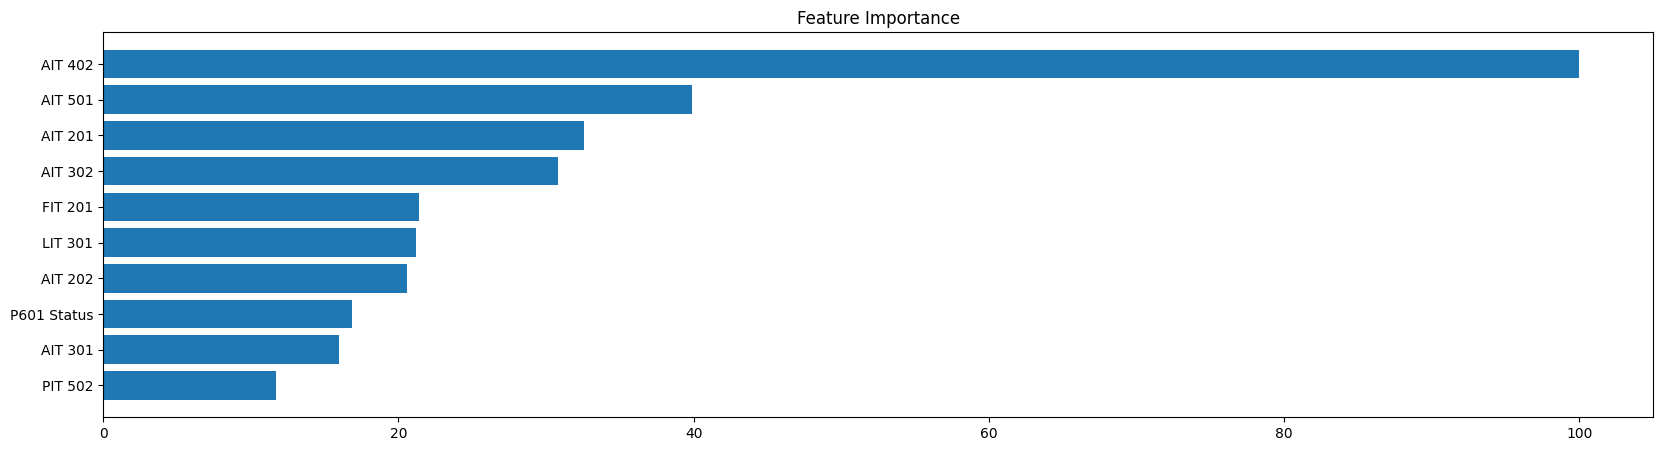

In [88]:
plot_feature_importance(xgboost, no_nan_df)

#### Training with non-shuffled data

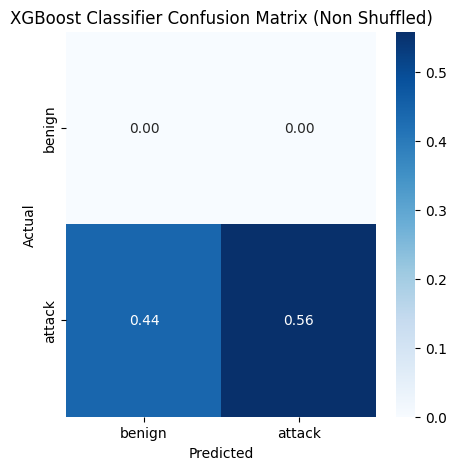

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
xgboost = gen_XGBoostClassifier()
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)
confusion_matrix_plot(y_test, y_pred, 'XGBoost Classifier Confusion Matrix (Non Shuffled)')

##### Feature importance

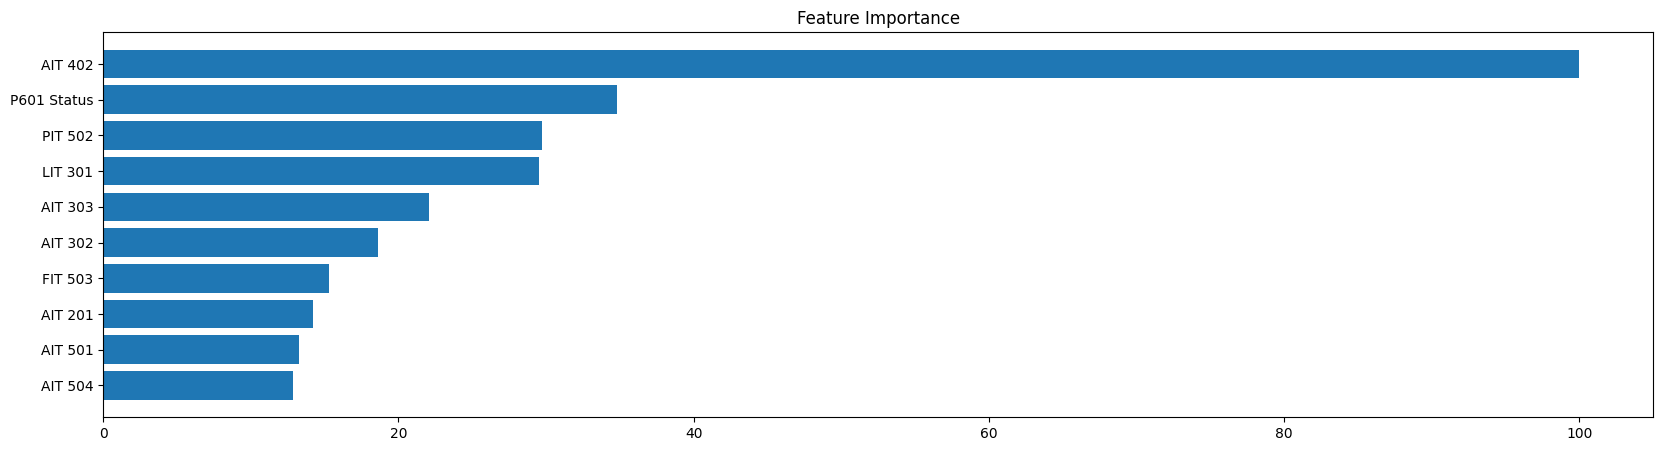

In [90]:
plot_feature_importance(xgboost, no_nan_df)

#### Cross-validation

In [91]:
cross_validate_model(X, y, gen_XGBoostClassifier, 'XGBoost', tscv)

precision    recall  f1-score  auprc_train
XGBoost        1.0  0.919608  0.954292     0.976104

In [92]:
plot_pca_with_predictions(X_test, y_test, y_pred)

### Multi-layer Perceptron Classifier

#### Training with shuffled data

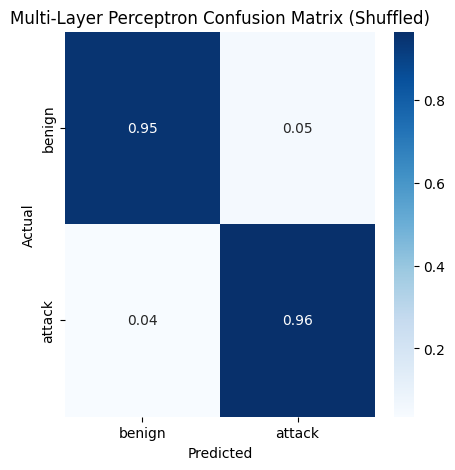

In [93]:
def gen_mlp() -> MLPClassifier:
    return MLPClassifier(
        hidden_layer_sizes=(256, 256),
        batch_size=64,
        learning_rate='adaptive',
        learning_rate_init=5e-3,
        random_state=seed,
        early_stopping=True,
        shuffle=False
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
mlp = gen_mlp()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
confusion_matrix_plot(y_test, y_pred, 'Multi-Layer Perceptron Confusion Matrix (Shuffled)')

In [94]:
print("AUPRC: ", average_precision_score(y_test, y_pred, average='weighted'))

AUPRC:  0.9345289041448903


#### Training with non-shuffled data

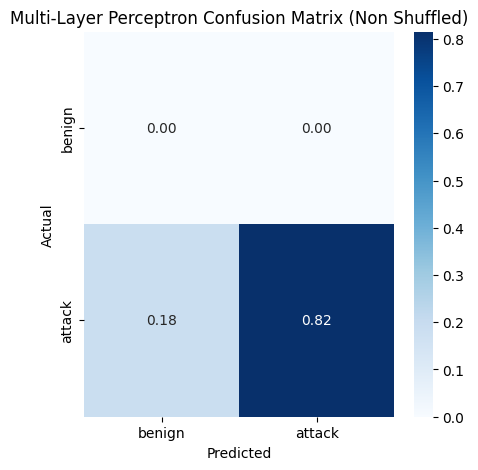

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
mlp = gen_mlp()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
confusion_matrix_plot(y_test, y_pred, 'Multi-Layer Perceptron Confusion Matrix (Non Shuffled)')

#### Cross-validation

In [96]:
cross_validate_model(X, y, gen_mlp, 'MLP', tscv)

precision    recall  f1-score  auprc_train
MLP        1.0  0.831373  0.887139     0.969406

In [97]:
plot_pca_with_predictions(X_test, y_test, y_pred)

## Multi-class classification

For the multi-class classification, we will use the same methodology as for the binary classification. However, we will only consider the XGBoost classifier, as it is the one that performed the best in the previous section.

### XGBoost Classifier

#### Training with shuffled data

In [98]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df_sampled['Attack'].to_numpy().reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
xgboost = gen_XGBoostClassifier()
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), zero_division=0))

auprc = average_precision_score(y_test, xgboost.predict_proba(X_test), average='weighted')
print(f'AUPRC: {auprc}')

              precision    recall  f1-score   support

           0       0.66      1.00      0.79        87
           1       1.00      1.00      1.00       138
           2       0.94      1.00      0.97        31
           3       1.00      1.00      1.00       263
           4       1.00      0.91      0.95       503

    accuracy                           0.95      1022
   macro avg       0.92      0.98      0.94      1022
weighted avg       0.97      0.95      0.96      1022

AUPRC: 0.9977090047123007


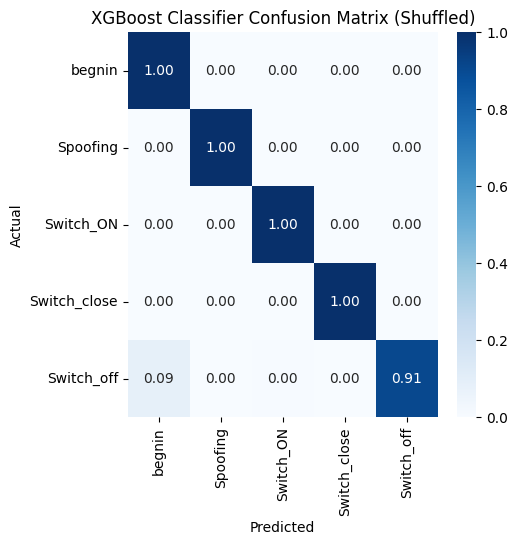

In [99]:
confusion_matrix_plot(
    y_test.argmax(axis=1),
    y_pred.argmax(axis=1),
    'XGBoost Classifier Confusion Matrix (Shuffled)',
    list_labels=['begnin', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off']
)

#### Training with non-shuffled data

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
xgboost = gen_XGBoostClassifier()
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), zero_division=0))

auprc = average_precision_score(y_test, xgboost.predict_proba(X_test), average='weighted')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           3       1.00      0.56      0.72      1022
           4       0.00      0.00      0.00         0

    accuracy                           0.56      1022
   macro avg       0.33      0.19      0.24      1022
weighted avg       1.00      0.56      0.72      1022



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.



In [101]:
cross_validate_model(X, y, gen_XGBoostClassifier, 'XGBoost', tscv)

precision    recall  f1-score  auprc_train
XGBoost        1.0  0.638235  0.762281     0.990365

In [102]:
plot_pca_with_predictions(X_test, y_test, y_pred)